In [25]:
using RegularizedSystems
using VSTom
using PyPlot
a = read_ncdf("data/reduced_synthetic_transfer_matrix.cdf")
transfer_matrix = a["transfer_matrix"]
energy = a["energy"]
nenergy = length(energy)

pitch = a["pitch"]
npitch = length(pitch)

dE = abs(energy[2]-energy[1]);
dP = abs(pitch[2]-pitch[1]);
E = ones(npitch)*energy';
P = pitch*ones(nenergy)';

In [2]:
function make_synthetic_data{T<:Real}(A::Array{T,2},dist::Array{T,2},n::T,b::T,dE::T,dP::T)
    y = (dE*dP) * (A*reshape(dist,length(dist)))
    
    scale = n*mean(sqrt(y))
    yerr = scale .* max(sqrt(y),sqrt(b)) .* randn(length(y))
    
    noisy_spectrum = y .+ yerr
    noisy_background = b .+ scale*sqrt(b).*randn(length(y))
    
    scale_est = n*mean(sqrt(abs(noisy_spectrum)))
    
    err = scale_est .* max(sqrt(abs(noisy_spectrum)),sqrt(abs(noisy_background)))
    
    return noisy_spectrum, err
end

make_synthetic_data (generic function with 1 method)

In [3]:
nrows,ncols = size(transfer_matrix)

flat = ones(npitch,nenergy)
flat *= (1e12)/sum(flat*dE*dP)
flat_spec = zeros(nrows,21)
flat_err = zeros(nrows,21)
# Generate synthetic data for varying error levels with the same background value
for (ind,n) in enumerate(0:.05:1)
    flat_spec[:,ind], flat_err[:,ind] = make_synthetic_data(transfer_matrix,flat,n,1.25e14,dE,dP);
end

In [4]:
function tsvd_analysis(A,spec,err,dist,dE,dP)
    RF = TSVDFunctional(A,spec,err)
    k = discrete_lcurve(RF,1:300)
    sol = minimize(RF,k;true_sol = dist*dE*dP)
    dens = sum(max(sol.x,0.0))
    dens_err = norm(sol.sigma)
    x = reshape(max(sol.x,0)/(dE*dP),size(dist)...)
    sigma = reshape(sol.sigma/(dE*dP),size(dist)...)
    reg_err = reshape(sol.reg_err/(dE*dP),size(dist)...)
    dx = x .- dist
    return x,sigma,reg_err, dx,dens,dens_err
end

tsvd_analysis (generic function with 1 method)

In [61]:
function tik1_analysis(A,spec,err,dist,dE,dP,L1E,L1p)
    nr,nc = size(A)
    RF = TikhonovFunctional(A,spec,err,(L1E,L1p))
    alpha = lcurve(RF;log_alpha_range=(5,20),nseeds=20)
    sol = minimize(RF,alpha;true_sol=dist*dE*dP)
    dens = sum(max(sol.x,0.0))
    dens_err = norm(sol.sigma)
    x = reshape(max(sol.x,0)/(dE*dP),size(dist)...)
    sigma = reshape(sol.sigma/(dE*dP),size(dist)...)
    reg_err = reshape(sol.reg_err/(dE*dP),size(dist)...)
    dx = x .- dist
    return x,sigma,reg_err,dx,dens,dens_err
end

tik1_analysis (generic function with 1 method)

In [69]:
function tik0_analysis(A,spec,err,dist,dE,dP,L1E,L1p)
    nr,nc = size(A)
    RF = TikhonovFunctional(A,spec,err,(eye(nc),))
    alpha = lcurve(RF;log_alpha_range=(-10,5))
    sol = minimize(RF,alpha,true_sol=dist*dE*dP)
    dens = sum(max(sol.x,0.0))
    dens_err = norm(sol.sigma)
    x = reshape(max(sol.x,0)/(dE*dP),size(dist)...)
    sigma = reshape(sol.sigma/(dE*dP),size(dist)...)
    reg_err = reshape(sol.reg_err/(dE*dP),size(dist)...)
    dx = x .- dist
    return x,sigma,reg_err,dx,dens,dens_err
end

tik0_analysis (generic function with 1 method)

In [26]:
nenergy = 20
npitch = 20
flat = ones(npitch,nenergy)
flat *= (1e12)/sum(flat*dE*dP)
A_full = transfer_matrix
energy_full = energy
pitch_full  = pitch

A,energy,pitch = resize_transfer_matrix(A_full,energy_full,pitch_full,nenergy,npitch);
dE = abs(energy[2]-energy[1])
dP = abs(pitch[2]-pitch[1]);
L1E,L1p = gradEP(energy,pitch);

In [70]:
flat_x = zeros(npitch,nenergy,20)
flat_sigma = zeros(npitch,nenergy,20)
flat_reg = zeros(npitch,nenergy,20)
flat_dx = zeros(npitch,nenergy,20)
flat_dens = zeros(20)
flat_dens_err = zeros(20);

In [71]:
for i=1:20
    flat_x[:,:,i],flat_sigma[:,:,i],flat_reg[:,:,i],flat_dx[:,:,i],flat_dens[i],flat_dens_err[i] = 
    tik0_analysis(A,flat_spec[:,i+1],flat_err[:,i+1],flat,dE,dP,L1E,L1p)
end

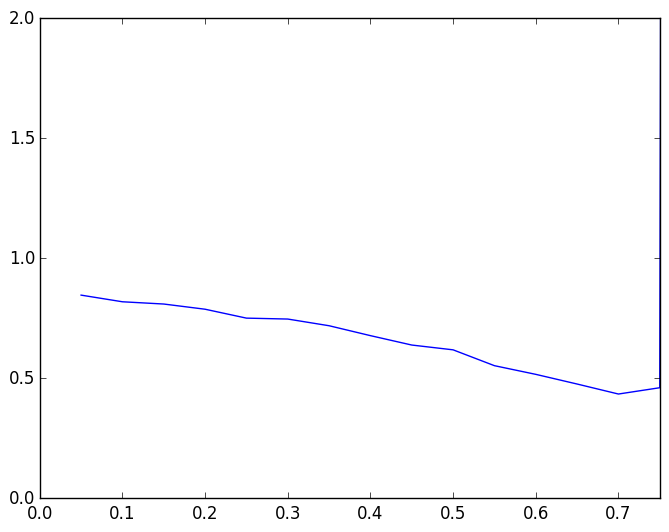

(0,2)

In [73]:
plot([0.05:0.05:1],flat_dens/(1e12))
xlim(0,.75)
ylim(0,2)

In [67]:
println(flat_dens[12]/1e12)

28.60942976562264


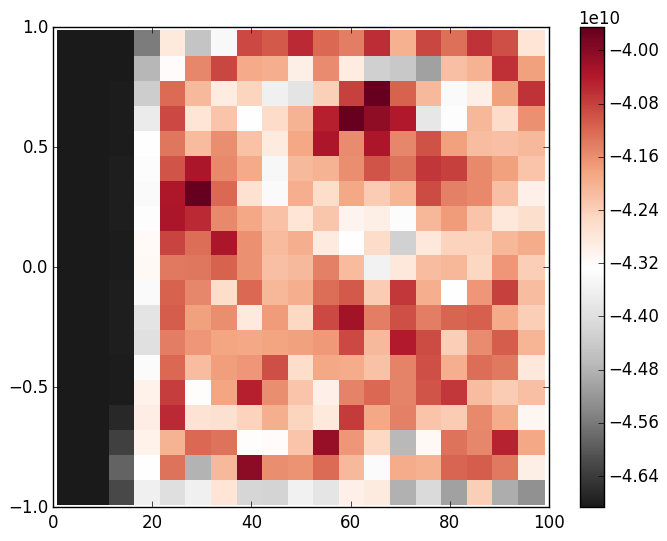

PyObject <matplotlib.colorbar.Colorbar object at 0x7f60c63da710>

In [75]:
pcolor(energy,pitch,flat_x[:,:,1] - flat[1,1],cmap="RdGy_r")
colorbar()